# TP: Estimation non paramétrique


Le but de ce TP est d'explorer différentes méthodes non paramétriques. 

1. Estimateur par projection de la densité
2. Kernel density estimators
3. Non-parametric regression using kernel methods
4. Non-parametric regression using projection methods

Le but sera d'implémenter chacun de ces modèles et d'étudier quelques propriétés comme le risque et les intervalles de confiance. 

In [235]:
import numpy as np
import scipy.stats as stats
from math import sqrt, pi, exp
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
np.random.seed(42)

## Données synthétiques:

### Densité:

In [236]:
def generate_univariate_data(distribution='normal', n_samples=500, params=None):
    if params is None:
        params = {}
    
    if distribution == 'normal':
        mu = params.get('mu', 0)
        sigma = params.get('sigma', 1)
        X = np.random.normal(mu, sigma, n_samples)
        true_density = lambda x: stats.norm.pdf(x, mu, sigma)
        
    elif distribution == 'mixture':
        mu1 = params.get('mu1', -2)
        mu2 = params.get('mu2', 2)
        sigma1 = params.get('sigma1', 0.5)
        sigma2 = params.get('sigma2', 0.5)
        weight = params.get('weight', 0.5)


        mask = np.random.rand(n_samples) < weight
        X = np.zeros(n_samples)
        X[mask] = np.random.normal(mu1, sigma1, mask.sum())
        X[~mask] = np.random.normal(mu2, sigma2, (~mask).sum())
        
        true_density = lambda x: weight * stats.norm.pdf(x, mu1, sigma1) + (1-weight) * stats.norm.pdf(x, mu2, sigma2)
    
    elif distribution == 'uniform':
        a = params.get('a', -3)
        b = params.get('b', 3)
        X = np.random.uniform(a, b, n_samples)
        true_density = lambda x: stats.uniform.pdf(x, a, b-a)
    
    return X, true_density

1. Représenter les trois densités que la fonction `generate_univariate_data` permet de simuler

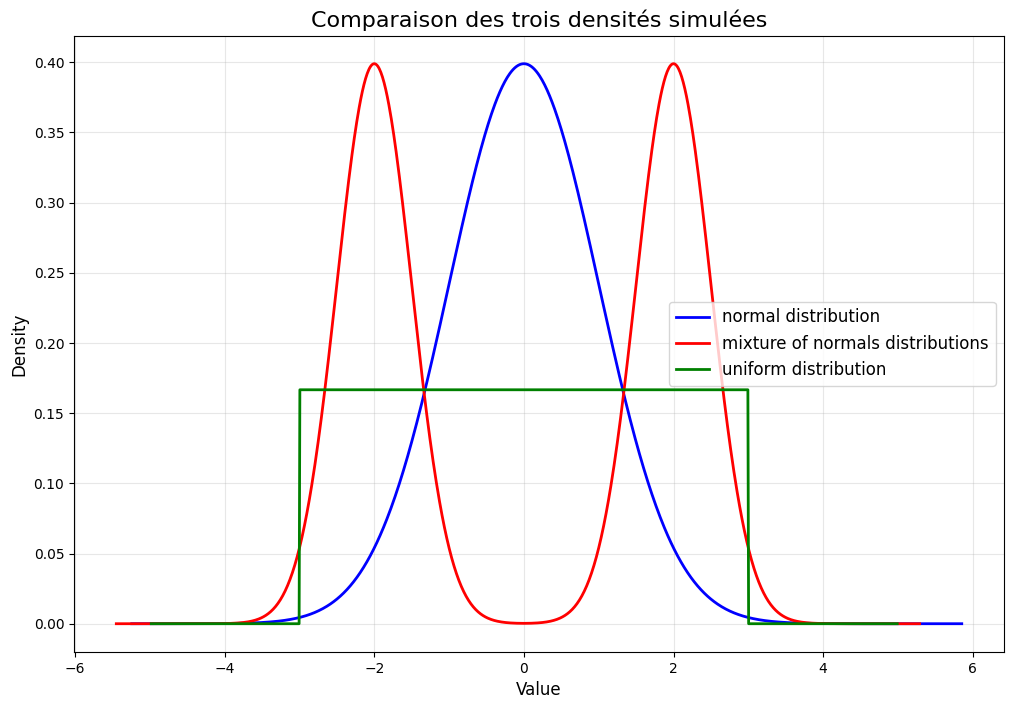

In [237]:
models_data = [generate_univariate_data(distribution=nom) for nom in ['normal', 'mixture', 'uniform']]
noms_models = ['normal distribution', 'mixture of normals distributions', 'uniform distribution']

plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green']

for i, ((X, true_density), model_name) in enumerate(zip(models_data, noms_models)):
    x_min, x_max = X.min() - 2, X.max() + 2
    x = np.linspace(x_min, x_max, 1000)
    
    plt.plot(x, true_density(x), color=colors[i], label=f'{model_name}', linewidth=2)

plt.title('Comparaison des trois densités simulées', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

### Regression:

In [238]:
def generate_regression_data(function_type='linear', n_samples=200, noise_level=0.5):
    X = np.sort(np.random.uniform(-5, 5, n_samples))
    
    if function_type == 'linear':
        true_function = lambda x: 2*x + 1
        y = true_function(X) + np.random.normal(0, noise_level, n_samples)
        
    elif function_type == 'sine':
        true_function = lambda x: np.sin(x)
        y = true_function(X) + np.random.normal(0, noise_level, n_samples)
        
    elif function_type == 'step':
        def step_function(x):
            return np.where(x < 0, 0, 1)
        true_function = step_function
        y = true_function(X) + np.random.normal(0, noise_level, n_samples)
    
    elif function_type == 'complex':
        true_function = lambda x: np.sin(x) + 0.5*x + 0.2*x**2 * np.exp(-0.1*x**2)
        y = true_function(X) + np.random.normal(0, noise_level, n_samples)
        
    else:
        raise ValueError(f"Function type {function_type} not implemented")
    
    return X, y, true_function

2. Représenter sur un même graphe les quatre modèles de régression que la fonction `generate_regression_data` permet de simuler.

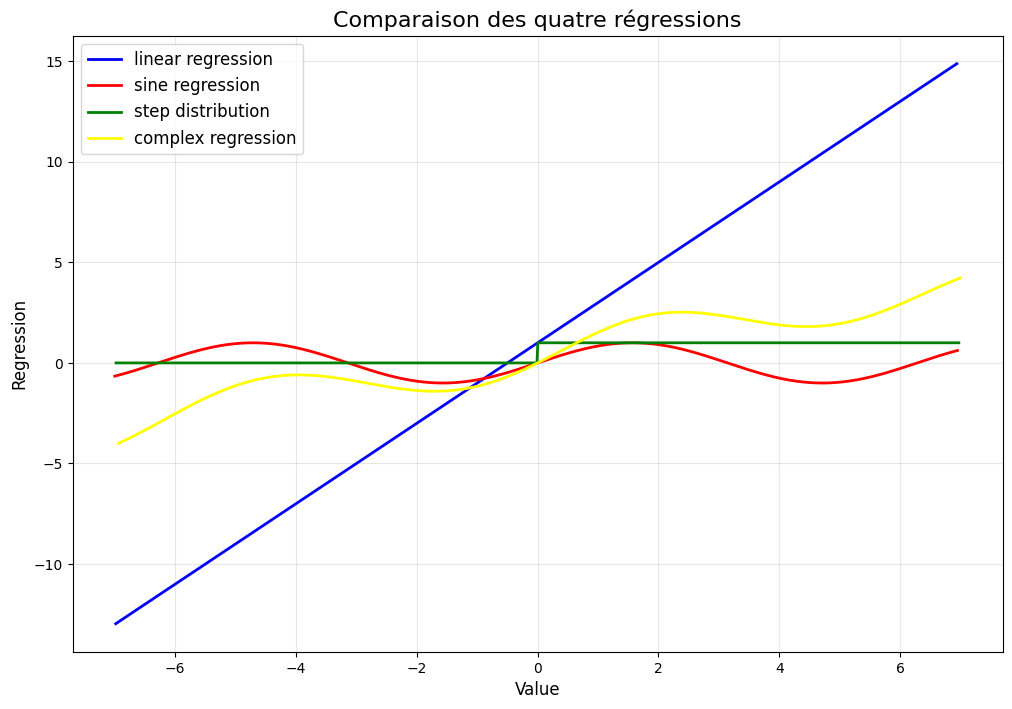

In [239]:
regression_data = [generate_regression_data(function_type=nom) for nom in ['linear', 'sine', 'step', 'complex']]
noms_models = ['linear regression', 'sine regression', 'step distribution', 'complex regression']

plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green', 'yellow']

for i, ((X, y, true_function), model_name) in enumerate(zip(regression_data, noms_models)):
    x_min, x_max = X.min() - 2, X.max() + 2
    x = np.linspace(x_min, x_max, 1000)
    
    plt.plot(x, true_function(x), color=colors[i], label=f'{model_name}', linewidth=2)

plt.title('Comparaison des quatre régressions', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Regression', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Estimation de la densité:

## Estimateur par projection:


1. Expliquer le principe de l'estimateur par projection.

> reponse:

>L'estimateur par projection consiste à approximer une densité inconnue en la décomposant sur une base de fonctions connues.

>Le principe est simple : au lieu d'essayer d'estimer directement la fonction densité f(x), on suppose qu'elle peut s'écrire comme une combinaison linéaire de fonctions simples φ₁, φ₂, ..., φₘ. 

>Autrement dit, f(x) ≈ a₁φ₁(x) + a₂φ₂(x) + ... + aₘφₘ(x).

>L'idée clé est de transformer le problème d'estimation d'une fonction entière en un problème d'estimation de quelques coefficients numériques aⱼ. 

>Pour cela, on utilise l'échantillon observé X₁, ..., Xₙ et on estime chaque coefficient par âⱼ = (1/n) Σᵢ φⱼ(Xᵢ), c'est-à-dire la moyenne empirique de la fonction de base φⱼ sur l'échantillon.

>Une fois les coefficients estimés, on reconstruit la densité par f̂(x) = Σⱼ âⱼ φⱼ(x). Le choix des fonctions de base (Fourier, polynômes, etc.) et du nombre m de termes détermine la qualité de l'approximation selon un compromis biais-variance.

L'objectif est de réaliser des expériences pour évaluer la méthode sur différentes bases de fonctions et divers jeux de données. Nous adoptons une approche orientée objet pour l'implémentation, où la classe `ProjectionEstimator` permet d'initialiser un estimateur par projection avec les méthodes suivantes :

- **`fit`** : estime les coefficients de la décomposition dans la base choisie
- **`evaluate`** : évalue la fonction estimée en un ensemble de points donnés  
- **`compute_error`** : calcule le risque quadratique intégré pour mesurer la performance de l'estimateur


1. À partir du prototype de classe donné ci-dessous, implémenter les méthodes de la classe `ProjectionEstimator`. Il faudra effectuer une transformation pour se ramener à l'intervalle $[0,1]$. Pour passer de l'intervalle $[0,1]$ à un intervalle quelconque $[a,b]$, on fait la transformation suivante:
$$
\tilde{\varphi_j}(x) =  \frac{1}{\sqrt{b-a}}\varphi_j\left( \frac{x-a}{b-a}  \right)
$$

In [240]:
class ProjectionEstimator:
    def __init__(self, basis_functions, domain=[0, 1], D=10):
        self.basis_functions = basis_functions
        self.a = domain[0]
        self.b = domain[1]
        self.coefficients = None
        self.dim = D
        
    def fit(self, x):
        self.coefficients = np.zeros(self.dim)
        for j in range(self.dim):
            phi_values = []
            for x_value in x:
                x_transformed = (x_value - self.a) / (self.b - self.a)
                x_transformed = np.clip(x_transformed, 0, 1)
                phi_values.append(self.basis_functions(x_transformed, d=self.dim)[j])
            self.coefficients[j] = np.mean(phi_values) / np.sqrt(self.b - self.a)
            
    def evaluate(self, x):
        evaluation = []
        for x_value in x:
            x_transformed = (x_value - self.a) / (self.b - self.a)
            x_transformed = np.clip(x_transformed, 0, 1)
            result = 0.0
            phi_all = self.basis_functions(x_transformed, d=self.dim)
            for j, coeff in enumerate(self.coefficients):
                phi_tilde = (1/np.sqrt(self.b - self.a)) * phi_all[j]
                result += coeff * phi_tilde
            evaluation.append(result)
        return np.array(evaluation)
        
    def compute_mise(self, true_density, n_test=5000):
        x_test = np.linspace(self.a, self.b, n_test)
        f_true = true_density(x_test)
        f_estimated = self.evaluate(x_test)
        mise = np.mean((f_true - f_estimated)**2) * (self.b - self.a)
        return mise


2. Implémenter les bases d'histogramme, trigonométrique, polynomiale par morceaux.

>Base d'histogrammes
>$$\forall j \in \{1,\ldots,D\}, \quad \forall x \in [0,1], \quad \varphi_j(x) = \mathbf{1}_{[\frac{j-1}{n}, \frac{j}{n}[}(x)  \quad \forall j \in \{1,\ldots,D\}$$

In [241]:
def histohistogram_basis(x, d=10):
    """
    Histogram basis on [0, 1] with d bins
    """
    basis = np.zeros(d)
    for j in range(1, d+1):
        left_bound = (j-1) / d
        right_bound = j / d
        if left_bound <= x < right_bound or (j == d and x == 1):
            basis[j-1] = np.sqrt(d)
    return basis
    


> Base trigonométrique
> $$
\forall j \in \{1,\ldots,D\}, \quad \forall x \in [0, 1], \quad
\begin{cases}
\varphi_1(x) = 1, \\
\varphi_{2j}(x) = \sqrt{2} \cos(2\pi j x), \\
\varphi_{2j+1}(x) = \sqrt{2} \sin(2\pi j x).
\end{cases}
$$

In [242]:
def trigonometric_basis(x, d=10):
    basis = np.zeros(d)
    basis[0] = 1.0
    idx = 1
    for k in range(1, (d+1)//2):
        if idx < d:
            basis[idx] = np.sqrt(2) * np.cos(2 * np.pi * k * x)
            idx += 1
        if idx < d:
            basis[idx] = np.sqrt(2) * np.sin(2 * np.pi * k * x)
            idx += 1
    return basis



> Base de polynômes par morceaux
> 
> Soit $Q_k$ le polynome de Legendre d'ordre k.
> Si $d$ et $r$ sont des entiers, on définit la famille de fonctions $(\varphi_{j,k}^{(d)})_{\substack{j=1,\ldots,d \\ k=0,\ldots,r}}$ par : $$\forall (j,k) \in \llbracket 1,d \rrbracket \times \llbracket 1,r \rrbracket, \forall x \in [0,1], \quad \varphi_{j,k}^{(d)}(x) = \sqrt{2d} \, Q_k(2dx - 2j + 1) \mathbb{1}_{\left[\frac{j-1}{d}, \frac{j}{d}\right]}(x).$$ 
> Cette famille est alors une base orthonormée de $S_D$ est en particulier de dimension $D = d(r+1)$. 

In [243]:
from scipy.special import eval_legendre

def polynome_par_morceaux(x, d=10, r=1):
    d_intervals = max(1, d // (r + 1))

    basis = np.zeros(d)
    idx = 0
    for j in range(1, d_intervals + 1):
        for k in range(0, r + 1):
            if idx >= d:
                break
            left_bound = (j - 1) / d_intervals
            right_bound = j / d_intervals
            
            if left_bound <= x < right_bound or (j == d_intervals and x == 1):
                u = 2 * d_intervals * x - 2 * j + 1
                basis[idx] = np.sqrt(2 * d_intervals) * np.sqrt(k + 0.5) * eval_legendre(k, u)
            idx += 1
        if idx >= d:
            break
    return basis


1. En utilisant la fonction `generate_univariate_data`, simuler un échantillon de taille $n=1000$ de la loi $\mathcal{N}(4,25)$ et estimer la densité avec les trois bases, on prendra $D=10$.

In [244]:
X_sample, true_density = generate_univariate_data(distribution='normal', n_samples=1000, params={'mu': 4, 'sigma': 5})

domain = [-11, 19]
D = 10

estimator_histo = ProjectionEstimator(histohistogram_basis, domain=domain, D=D)
estimator_trig = ProjectionEstimator(trigonometric_basis, domain=domain, D=D)
estimator_poly = ProjectionEstimator(polynome_par_morceaux, domain=domain, D=D)

estimator_histo.fit(X_sample)
estimator_trig.fit(X_sample)
estimator_poly.fit(X_sample)

2. Représenter la vraie densité et les trois estimations obtenues sur une même figure

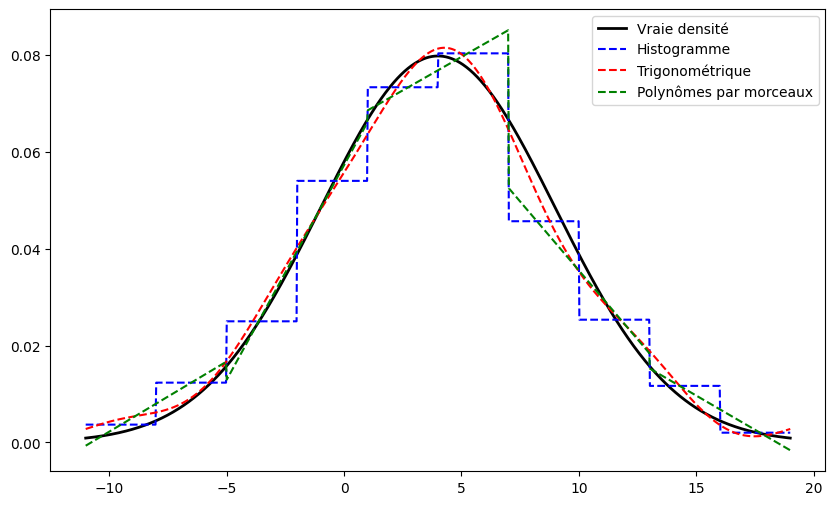

In [245]:
x_grid = np.linspace(domain[0], domain[1], 1000)

plt.figure(figsize=(10, 6))
plt.plot(x_grid, true_density(x_grid), 'k-', linewidth=2, label='Vraie densité')
plt.plot(x_grid, estimator_histo.evaluate(x_grid), 'b--', label='Histogramme')
plt.plot(x_grid, estimator_trig.evaluate(x_grid), 'r--', label='Trigonométrique')
plt.plot(x_grid, estimator_poly.evaluate(x_grid), 'g--', label='Polynômes par morceaux')
plt.legend()
plt.show()

3. Analyser le risque empirique en fonction de la dimension de la base pour chaque choix de base

Analyse du risque en fonction de la dimension...
Dimension 2...
Dimension 3...
Dimension 4...
Dimension 5...
Dimension 6...
Dimension 7...
Dimension 8...
Dimension 9...
Dimension 10...
Dimension 11...
Dimension 12...
Dimension 13...
Dimension 14...
Dimension 15...
Dimension 16...
Dimension 17...
Dimension 18...
Dimension 19...
Dimension 20...


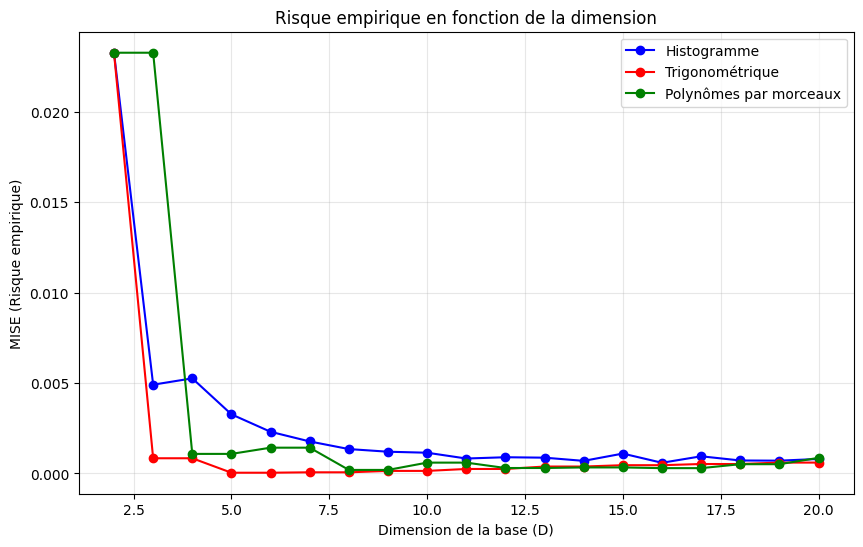


Dimensions optimales :
Histogramme: D = 16
Trigonométrique: D = 5
Polynômes: D = 8


In [246]:
dimensions = range(2, 21) 

mise_histo = []
mise_trig = []
mise_poly = []


print("Analyse du risque en fonction de la dimension...")

for d in dimensions:
    print(f"Dimension {d}...")
    
    # Créer et ajuster les estimateurs
    est_histo = ProjectionEstimator(histohistogram_basis, domain=domain, D=d)
    est_trig = ProjectionEstimator(trigonometric_basis, domain=domain, D=d)
    est_poly = ProjectionEstimator(polynome_par_morceaux, domain=domain, D=d)
    
    est_histo.fit(X_sample)
    est_trig.fit(X_sample)
    est_poly.fit(X_sample)
    
    # utilisation de MISE
    mise_histo.append(est_histo.compute_mise(true_density))
    mise_trig.append(est_trig.compute_mise(true_density))
    mise_poly.append(est_poly.compute_mise(true_density))

# Graphique
plt.figure(figsize=(10, 6))
plt.plot(dimensions, mise_histo, 'bo-', label='Histogramme')
plt.plot(dimensions, mise_trig, 'ro-', label='Trigonométrique')
plt.plot(dimensions, mise_poly, 'go-', label='Polynômes par morceaux')
plt.xlabel('Dimension de la base (D)')
plt.ylabel('MISE (Risque empirique)')
plt.title('Risque empirique en fonction de la dimension')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Résultats
print("\nDimensions optimales :")
print(f"Histogramme: D = {dimensions[np.argmin(mise_histo)]}")
print(f"Trigonométrique: D = {dimensions[np.argmin(mise_trig)]}")
print(f"Polynômes: D = {dimensions[np.argmin(mise_poly)]}")

4. À présent on se restreint à l'utilisation de la base de polynômes par morceaux et on cherche à retrouver la valeur optimale du paramètre $D$. Pour faire ça on cherche un D tel que celui-ci minimise la borne supérieure sur le risque. $$D^* = \text{argmin}_{D} \left\{ -\| \hat{f}_{D} \|  + K\phi_{0}^2  \frac{D}{n}\right\} = \text{argmin}_{D} \left\{ -\sum_{j=1}^{j=D}a_{j}^2  + K\phi_{0}^2  \frac{D}{n}\right\}$$
faire la sélection de modèle. 

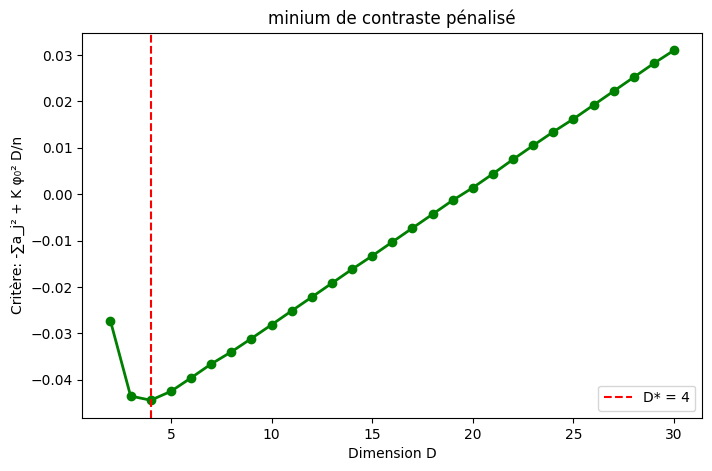

D optimal: 4
r optimal for D: 1


In [247]:
# pour cette question ajout d'une partie pour optimiser le choix de r pour chaque D
# et choix arbitraire de K=1.0
def find_optimal_D_exact(X_sample, domain, K=1.0):
    n = len(X_sample)
    dimensions = range(2, 31)
    criteria = []
    phi_0 = np.sqrt(3)
    list_r = []
    
    for D in dimensions:
        best_criterion_for_D = float('inf')
        best_r = 1
        
        for r in range(1, 6):
            if r+1 > D:
                continue
            
            def polynome_r(x, d=10):
                return polynome_par_morceaux(x, d, r)
            
            estimator = ProjectionEstimator(polynome_r, domain=domain, D=D)
            estimator.fit(X_sample)
            
            fit_term = -np.sum(estimator.coefficients**2)
            complexity_term = K * (phi_0**2) * D / n
            criterion = fit_term + complexity_term
            
            if criterion < best_criterion_for_D:
                best_criterion_for_D = criterion
                best_r = r
        
        criteria.append(best_criterion_for_D)
        list_r.append(best_r)
    
    D_optimal = dimensions[np.argmin(criteria)]
    best_r = list_r[np.argmin(criteria)]
    return D_optimal, criteria, best_r

X_sample, true_density = generate_univariate_data(distribution='normal', n_samples=1000, params={'mu': 4, 'sigma': 5})
domain = [-11, 19]

D_optimal, criteria, r_optimal_for_D = find_optimal_D_exact(X_sample, domain)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 31), criteria, 'go-', linewidth=2)
plt.axvline(D_optimal, color='red', linestyle='--',
            label=f'D* = {D_optimal}')
plt.xlabel('Dimension D')
plt.ylabel('Critère: -∑a_j² + K φ₀² D/n')
plt.title('minium de contraste pénalisé')
plt.legend()
plt.show()

print(f"D optimal: {D_optimal}")
print(f"r optimal for D: {r_optimal_for_D}")

5. Représenter les estimateurs candidats sur un graphe et l'estimateur optimal sur un autre graphe. 

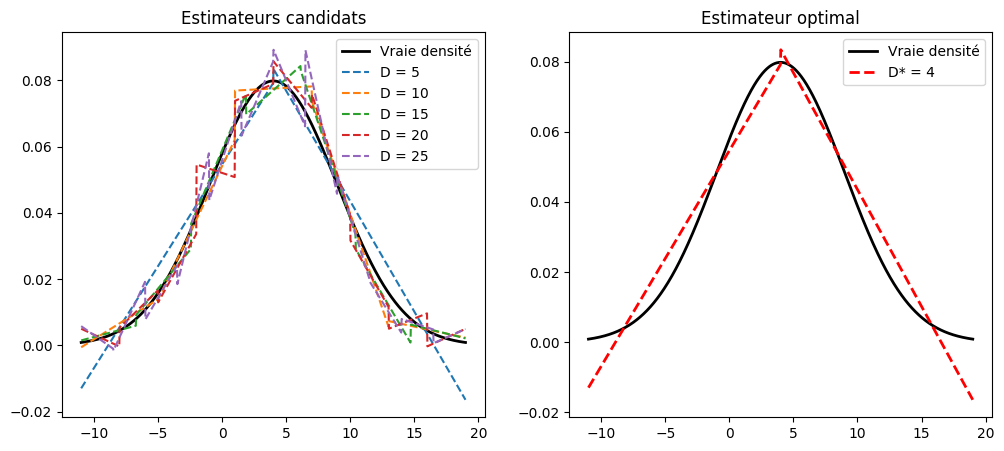

In [248]:
D_candidats = [5, 10, 15, 20, 25]
x_grid = np.linspace(domain[0], domain[1], 1000)


plt.figure(figsize=(12, 5))

# candidats
plt.subplot(1, 2, 1)
plt.plot(x_grid, true_density(x_grid), 'k-', linewidth=2, label='Vraie densité')

for D in D_candidats:
    estimator = ProjectionEstimator(polynome_par_morceaux, domain=domain, D=D)
    estimator.fit(X_sample)
    values = estimator.evaluate(x_grid)
    plt.plot(x_grid, values, '--', label=f'D = {D}')

plt.title('Estimateurs candidats')
plt.legend()

# optimal
plt.subplot(1, 2, 2)
plt.plot(x_grid, true_density(x_grid), 'k-', linewidth=2, label='Vraie densité')

estimator_opt = ProjectionEstimator(polynome_par_morceaux, domain=domain, D=D_optimal)
estimator_opt.fit(X_sample)
opt_values = estimator_opt.evaluate(x_grid)
plt.plot(x_grid, opt_values, 'r--', linewidth=2, label=f'D* = {D_optimal}')

plt.title('Estimateur optimal')
plt.legend()

plt.show()

## Estimateur des noyaux:


3. Expliquer le principe de l'estimation de densité par noyaux.

> réponse

> L'estimation par noyaux place une fonction de probabilité (noyau) centrée sur chaque observation et fait la moyenne :
f̂ₕ(x) = (1/nh) Σᵢ₌₁ⁿ K((x - Xᵢ)/h)

>où :

>K est la fonction noyau (gaussienne, uniforme, etc.)

>h est le bandwidth qui contrôle le lissage

>n est la taille de l'échantillon

>Idée : A la place d'un histogramme avec des rectangles, on place une fonction lisse sur chaque point de données. Le paramètre h contrôle le compromis biais-variance.

4. En utilisant le prototype de classe `KernelDensityEstimator` ci-dessous, implémenter l'estimateur à noyaux de la densité

In [249]:
class KernelDensityEstimator:
    def __init__(self, kernel, bandwidth):
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.X_train = None
        
    def fit(self, x):
        self.X_train = np.array(x)
        
    def evaluate(self, x):
        result = np.zeros_like(x, dtype=float)
        
        for i, x_val in enumerate(x):
            result[i] = np.mean([self.kernel(data - x_val, self.bandwidth) for data in self.X_train]) / self.bandwidth
        
        return result
        
    def compute_mise(self, true_density, n_points=1000):
        if self.X_train is None:
            raise ValueError("Estimateur non ajusté")
        
        x_min, x_max = self.X_train.min() - 3*self.bandwidth, self.X_train.max() + 3*self.bandwidth
        x_test = np.linspace(x_min, x_max, n_points)
        
        f_true = true_density(x_test)
        f_estimated = self.evaluate(x_test)
        
        mise = np.mean((f_true - f_estimated)**2) * (x_max - x_min)
        return mise

1. Implémenter les noyaux gaussien, epanechnikov et uniforme.

In [250]:
def gaussian_kernel(x, bandwidth):
    return np.exp(-0.5 * (x / bandwidth)**2) / np.sqrt(2 * np.pi)

def uniform_kernel(x, bandwidth):
    u = np.abs(x / bandwidth)
    return np.where(u <= 1, 0.5, 0)

def triangular_kernel(x, bandwidth):
    u = np.abs(x / bandwidth)
    return np.where(u <= 1, 1 - u, 0)

def epanechnikov_kernel(x, bandwidth):
    u = np.abs(x / bandwidth)
    return np.where(u <= 1, 0.75 * (1 - u**2), 0)

2. Simuler avec `generate_univariate_data` un échantillon $n=1000$ de lois de mélange $(0.1 \mathcal{N}(-2,1)+0.9\mathcal{N}(2,1))$ et estimer la densité avec la méthode des noyaux en comparant tous les noyaux. 

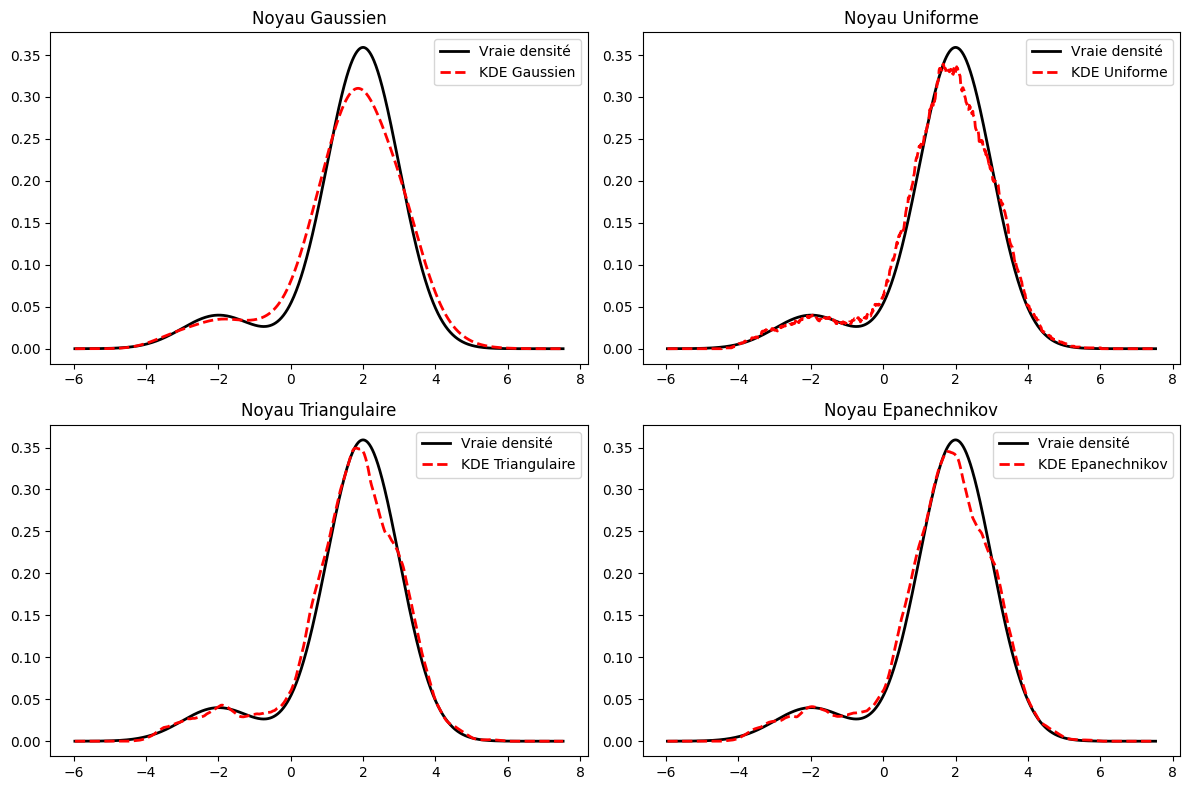

In [251]:
X_sample, true_density = generate_univariate_data('mixture', n_samples=1000, 
                                                  params={'mu1': -2, 'mu2': 2, 'sigma1': 1, 'sigma2': 1, 'weight': 0.1})

kernels = [gaussian_kernel, uniform_kernel, triangular_kernel, epanechnikov_kernel]
kernel_names = ['Gaussien', 'Uniforme', 'Triangulaire', 'Epanechnikov']

bandwidth = 0.5
domain = [X_sample.min() - 2, X_sample.max() + 2]
x_grid = np.linspace(domain[0], domain[1], 1000)

plt.figure(figsize=(12, 8))

for i, (kernel, name) in enumerate(zip(kernels, kernel_names)):
    kde = KernelDensityEstimator(kernel, bandwidth)
    kde.fit(X_sample)
    kde_values = kde.evaluate(x_grid)
    
    plt.subplot(2, 2, i+1)
    plt.plot(x_grid, true_density(x_grid), 'k-', linewidth=2, label='Vraie densité')
    plt.plot(x_grid, kde_values, 'r--', linewidth=2, label=f'KDE {name}')
    plt.title(f'Noyau {name}')
    plt.legend()

plt.tight_layout()
plt.show()

3. Représenter la vraie densité et les trois estimations obtenues sur une même figure puis analyser le risque empirique en fonction de la dimension de la base pour chaque choix de base.

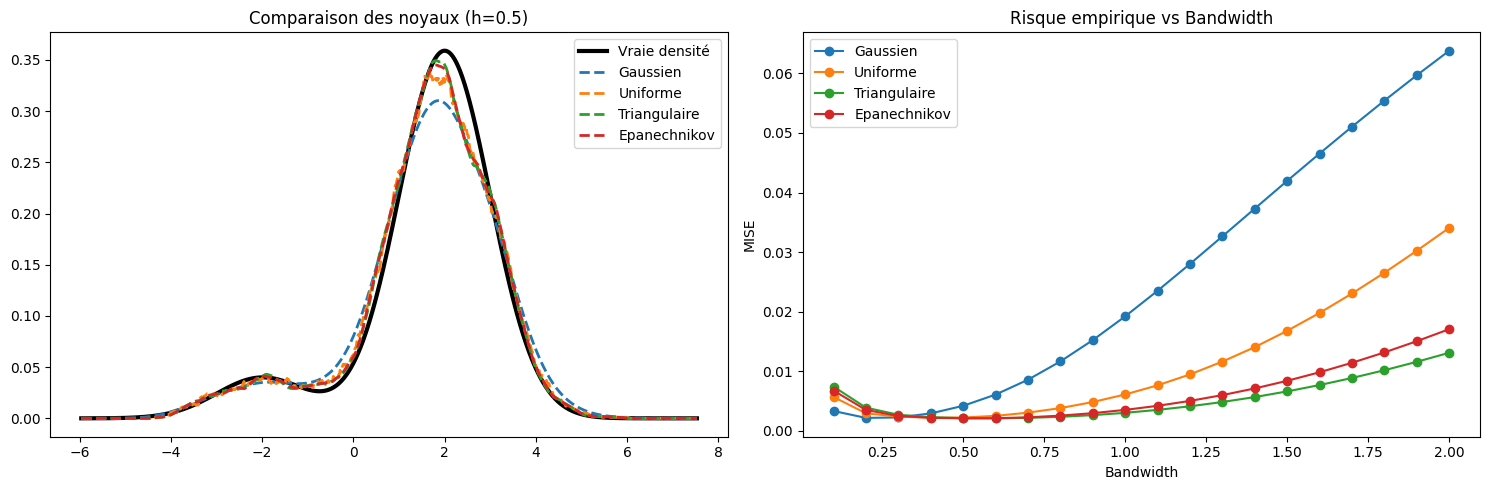

Gaussien: bandwidth optimal = 0.20
Uniforme: bandwidth optimal = 0.40
Triangulaire: bandwidth optimal = 0.60
Epanechnikov: bandwidth optimal = 0.50


In [252]:
# on teste plusieurs tailles de fenêtre (bandwidths) pour chaque noyau, à la suite d'un premier calcul j'avais trouvé:
# Gaussien: bandwidth optimal = 0.30
# Uniforme: bandwidth optimal = 0.50
# Triangulaire: bandwidth optimal = 0.70
# Epanechnikov: bandwidth optimal = 0.60
# donc on réduit la plage de recherche pour gagner du temps de calcul

bandwidths = np.linspace(0.1, 2.0, 20)
mise_results = {name: [] for name in kernel_names}

for bw in bandwidths:
    for kernel, name in zip(kernels, kernel_names):
        kde = KernelDensityEstimator(kernel, bw)
        kde.fit(X_sample)
        mise = kde.compute_mise(true_density)
        mise_results[name].append(mise)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x_grid, true_density(x_grid), 'k-', linewidth=3, label='Vraie densité')
for kernel, name in zip(kernels, kernel_names):
    kde = KernelDensityEstimator(kernel, 0.5)
    kde.fit(X_sample)
    kde_values = kde.evaluate(x_grid)
    plt.plot(x_grid, kde_values, '--', linewidth=2, label=f'{name}')
plt.title('Comparaison des noyaux (h=0.5)')
plt.legend()

plt.subplot(1, 2, 2)
for name in kernel_names:
    plt.plot(bandwidths, mise_results[name], 'o-', label=f'{name}')
plt.xlabel('Bandwidth')
plt.ylabel('MISE')
plt.title('Risque empirique vs Bandwidth')
plt.legend()

plt.tight_layout()
plt.show()

for name in kernel_names:
    optimal_idx = np.argmin(mise_results[name])
    optimal_bw = bandwidths[optimal_idx]
    print(f"{name}: bandwidth optimal = {optimal_bw:.2f}")

4. Énoncer le critère à minimiser pour le choix de la fenêtre. Effectuer la validation de modèle pour le noyau d'Epanechnikov.

> réponse

>Le choix optimal du bandwidth h minimise le MISE (Mean Integrated Squared Error) :

>MISE(h) = E[∫(f̂ₕ(x) - f(x))² dx]

>En pratique, on utilise souvent la validation croisée qui estime ce critère :

>CV(h) = ∫f̂ₕ(x)² dx - (2/n)Σᵢf̂ₕ⁻ⁱ(Xᵢ)
où f̂ₕ⁻ⁱ est l'estimateur calculé sans l'observation Xᵢ.

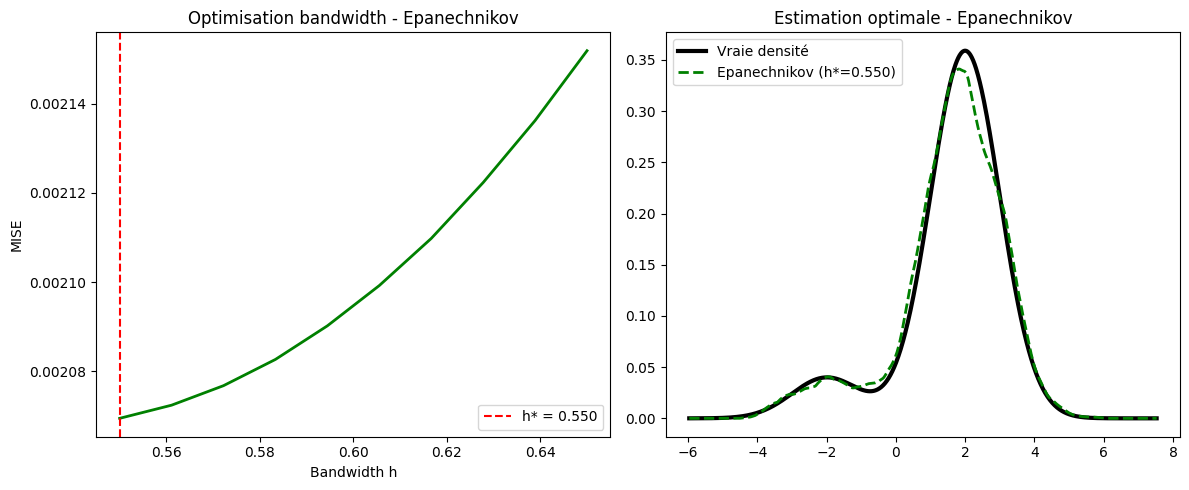

In [253]:
def find_optimal_bandwidth(X_sample, true_density, kernel_func, h_range):
    mise_values = []
    
    for h in h_range:
        kde = KernelDensityEstimator(kernel_func, h)
        kde.fit(X_sample)
        mise = kde.compute_mise(true_density)
        mise_values.append(mise)
    
    optimal_idx = np.argmin(mise_values)
    return h_range[optimal_idx], mise_values

# validation pour Epanechnikov
# d'après les premiers calculs (question précédente), on sait que le meilleur h est autour de 0.6 donc on peut affiner la recherche
h_range = np.linspace(0.55, 0.65, 10)
h_optimal_epan, mise_epan = find_optimal_bandwidth(X_sample, true_density, epanechnikov_kernel, h_range)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(h_range, mise_epan, 'g-', linewidth=2)
plt.axvline(h_optimal_epan, color='red', linestyle='--', label=f'h* = {h_optimal_epan:.3f}')
plt.xlabel('Bandwidth h')
plt.ylabel('MISE')
plt.title('Optimisation bandwidth - Epanechnikov')
plt.legend()

plt.subplot(1, 2, 2)
x_grid = np.linspace(X_sample.min()-2, X_sample.max()+2, 1000)
plt.plot(x_grid, true_density(x_grid), 'k-', linewidth=3, label='Vraie densité')

kde_epan = KernelDensityEstimator(epanechnikov_kernel, h_optimal_epan)
kde_epan.fit(X_sample)
epan_values = kde_epan.evaluate(x_grid)
plt.plot(x_grid, epan_values, 'g--', linewidth=2, label=f'Epanechnikov (h*={h_optimal_epan:.3f})')

plt.title('Estimation optimale - Epanechnikov')
plt.legend()

plt.tight_layout()
plt.show()

## Regression non-parametrique par moindres carrés:

1. Rappeler le principe de la régression non paramétrique par moindres carrés.

> réponse

> La régression non paramétrique par moindres carrés estime la fonction de régression m(x) = E[Y|X=x] en la décomposant sur une base de fonctions :
m(x) ≈ Σⱼ aⱼ φⱼ(x)

>Les coefficients sont estimés en minimisant la somme des carrés des résidus :
min Σᵢ [Yᵢ - Σⱼ aⱼ φⱼ(Xᵢ)]²

>La solution est : â = (Φᵀ Φ)⁻¹ Φᵀ Y où Φ est la matrice des fonctions de base.

3. Compléter la classe `NonParametric_Least_Squares` pour réaliser l'estimation non paramétrique de la fonction de régression.  

In [254]:
class NonParametric_Least_Squares:
    def __init__(self, basis_functions, domain=[0, 1], d=10):
        self.basis_functions = basis_functions
        self.domain = domain
        self.a = domain[0]
        self.b = domain[1]
        self.coefficients = None
        self.dim = d
        
    def fit(self, x, y):
        n = len(x)
        
        x_test = (x[0] - self.a) / (self.b - self.a)
        x_test = np.clip(x_test, 0, 1)
        basis_values = self.basis_functions(x_test, d=self.dim) 
        
        Phi = np.zeros((n, self.dim))
        for i, x_val in enumerate(x):
            x_transformed = (x_val - self.a) / (self.b - self.a)
            x_transformed = np.clip(x_transformed, 0, 1)
            Phi[i, :] = self.basis_functions(x_transformed, d=self.dim)
        
        self.coefficients = np.linalg.pinv(Phi.T @ Phi) @ Phi.T @ y
        
    def evaluate(self, x):
        if self.coefficients is None:
            raise ValueError("Le modèle doit être ajusté d'abord")
        
        was_scalar = np.isscalar(x)
        if was_scalar:
            x = np.array([x])
            
        result = np.zeros_like(x, dtype=float)
        m = len(self.coefficients)
        
        for i, x_val in enumerate(x):
            x_transformed = (x_val - self.a) / (self.b - self.a)
            x_transformed = np.clip(x_transformed, 0, 1)
            basis_values = self.basis_functions(x_transformed, d=m)
            result[i] = np.dot(self.coefficients, basis_values)
        
        return result[0] if was_scalar else result
        
    def compute_mse(self, true_function, n_test=1000):
        x_test = np.linspace(self.a, self.b, n_test)
        y_true = true_function(x_test)
        y_estimated = self.evaluate(x_test)
        return np.mean((y_true - y_estimated)**2)

4. Estimer pour chaque jeu de données la fonction de régression

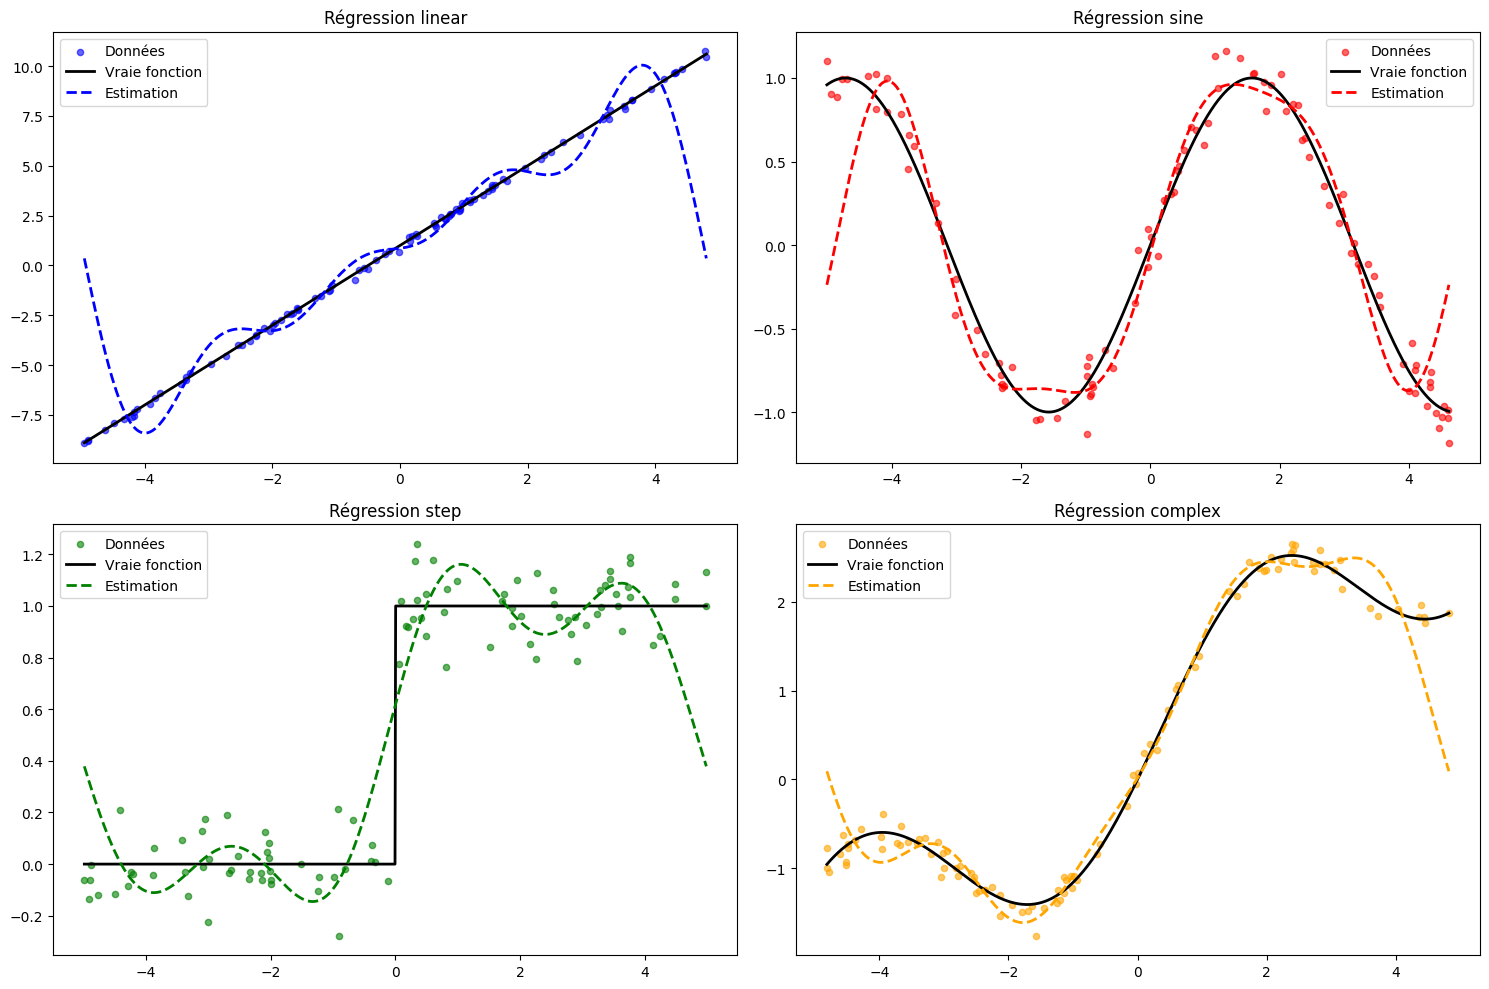

In [255]:
regression_types = ['linear', 'sine', 'step', 'complex']
colors = ['blue', 'red', 'green', 'orange']

plt.figure(figsize=(15, 10))

for i, reg_type in enumerate(regression_types):
    X_sample, y_sample, true_function = generate_regression_data(function_type=reg_type, n_samples=100, noise_level=0.1)
    
    domain = [X_sample.min(), X_sample.max()]
    regressor = NonParametric_Least_Squares(trigonometric_basis, domain=domain)
    regressor.fit(X_sample, y_sample)
    
    x_grid = np.linspace(domain[0], domain[1], 1000)
    y_pred = regressor.evaluate(x_grid)
    y_true = true_function(x_grid)
    
    plt.subplot(2, 2, i+1)
    plt.scatter(X_sample, y_sample, alpha=0.6, s=20, color=colors[i], label='Données')
    plt.plot(x_grid, y_true, 'k-', linewidth=2, label='Vraie fonction')
    plt.plot(x_grid, y_pred, '--', color=colors[i], linewidth=2, label='Estimation')
    plt.title(f'Régression {reg_type}')
    plt.legend()

plt.tight_layout()
plt.show()

5. Étudier le risque empirique en fonction de la dimension de l'espace $D$

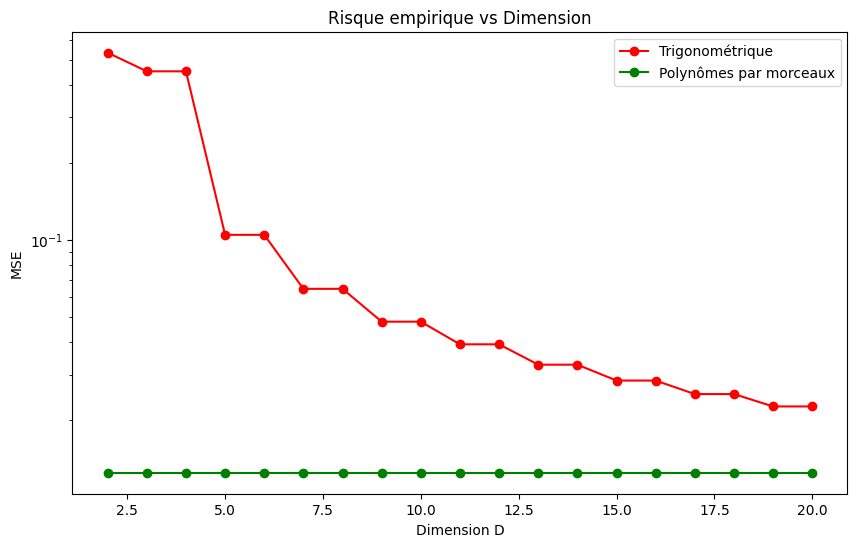

D optimal trigonométrique: 19
D optimal polynômes: 2


In [256]:
dimensions = range(2, 21)
X_reg, y_reg, true_func = generate_regression_data('sine', n_samples=150, noise_level=0.1)
domain = [X_reg.min(), X_reg.max()]

mse_trig = []
mse_poly = []

for D in dimensions:
    reg_trig = NonParametric_Least_Squares(trigonometric_basis, domain=domain, d=D)
    reg_trig.fit(X_reg, y_reg)
    mse_trig.append(reg_trig.compute_mse(true_func))
    
    reg_poly = NonParametric_Least_Squares(polynome_par_morceaux, domain=domain)
    reg_poly.fit(X_reg, y_reg)
    mse_poly.append(reg_poly.compute_mse(true_func))

plt.figure(figsize=(10, 6))
plt.plot(dimensions, mse_trig, 'ro-', label='Trigonométrique')
plt.plot(dimensions, mse_poly, 'go-', label='Polynômes par morceaux')
plt.xlabel('Dimension D')
plt.ylabel('MSE')
plt.title('Risque empirique vs Dimension')
plt.legend()
plt.yscale('log')
plt.show()

print(f"D optimal trigonométrique: {dimensions[np.argmin(mse_trig)]}")
print(f"D optimal polynômes: {dimensions[np.argmin(mse_poly)]}")

6. Pour la base trigonométrique. Énoncer le critère à minimiser pour retrouver la dimension optimale $D$ et retrouver cette valeur. 

> Critère à minimiser pour l'estimation de D: = RSS + K × D × σ̂² / n

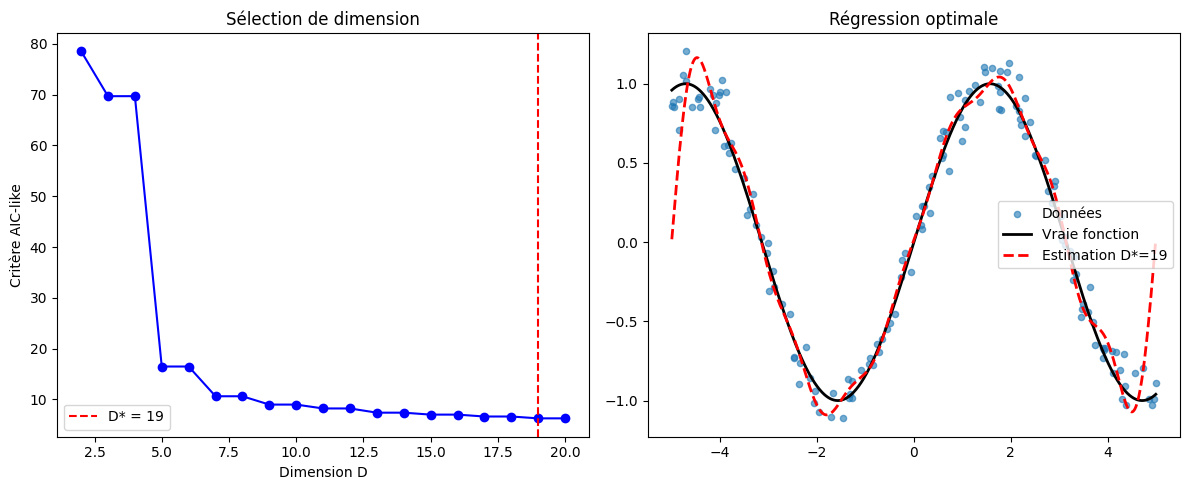

Dimension optimale: D* = 19


In [257]:
def find_optimal_D_regression(X_reg, y_reg, true_func, K=2.0):
    n = len(X_reg)
    dimensions = range(2, 21)
    criteria = []
    domain = [X_reg.min(), X_reg.max()]
    
    for D in dimensions:
        regressor = NonParametric_Least_Squares(trigonometric_basis, domain=domain, d=D)
        regressor.fit(X_reg, y_reg)
        
        # Calcul résidus
        y_pred_train = regressor.evaluate(X_reg)
        residual_sum = np.sum((y_reg - y_pred_train)**2)
        
        # Critère: RSS + K*D*sigma²/n
        sigma_squared = residual_sum / (n - D) if n > D else residual_sum / n
        criterion = residual_sum + K * D * sigma_squared / n
        criteria.append(criterion)
    
    D_optimal = dimensions[np.argmin(criteria)]
    return D_optimal, criteria

D_opt, criteria = find_optimal_D_regression(X_reg, y_reg, true_func)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 21), criteria, 'bo-')
plt.axvline(D_opt, color='red', linestyle='--', label=f'D* = {D_opt}')
plt.xlabel('Dimension D')
plt.ylabel('Critère AIC-like')
plt.title('Sélection de dimension')
plt.legend()

plt.subplot(1, 2, 2)
reg_opt = NonParametric_Least_Squares(trigonometric_basis, domain=[X_reg.min(), X_reg.max()], d=D_opt)
reg_opt.fit(X_reg, y_reg)

x_grid = np.linspace(X_reg.min(), X_reg.max(), 1000)
y_pred_opt = reg_opt.evaluate(x_grid)

plt.scatter(X_reg, y_reg, alpha=0.6, s=20, label='Données')
plt.plot(x_grid, true_func(x_grid), 'k-', linewidth=2, label='Vraie fonction')
plt.plot(x_grid, y_pred_opt, 'r--', linewidth=2, label=f'Estimation D*={D_opt}')
plt.title('Régression optimale')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Dimension optimale: D* = {D_opt}")

## Méthode Bootstrap pour les intervalles de Confiance


Imaginez que vous voulez connaître la précision de votre estimateur (par exemple, un estimateur de densité). En général, vous n'avez qu'un seul échantillon de données, mais vous aimeriez savoir comment votre estimateur se comporterait si vous pouviez répéter l'expérience plusieurs fois. Le bootstrap résout ce problème en simulant de nombreux échantillons à partir de vos données originales.

#### Procedure de bootstrap
1. **Données originales** : Vous avez un échantillon $X_1, X_2, \ldots, X_n$
2. **Rééchantillonnage** : Vous tirez avec remise $n$ observations de votre échantillon original pour créer un "échantillon bootstrap" $X_1^*, X_2^*, \ldots, X_n^*$
3. **Calcul** : Vous calculez votre estimateur sur cet échantillon bootstrap
4. **Répétition** : Vous répétez les étapes 2-3 un grand nombre de fois (typiquement 100-1000 fois)
5. **Distribution bootstrap** : L'ensemble des estimateurs calculés forme une approximation de la distribution d'échantillonnage

### Construction des intervalles de confiance
1. **Estimateur original** : Calculer l'estimateur sur les données originales
2. **Bootstrap** : Générer B échantillons bootstrap et calculer l'estimateur sur chacun
3. **Quantiles** : Calculer les quantiles $\alpha/2$ et $1-\alpha/2$ des estimateurs bootstrap
4. **Bandes** : Les quantiles forment les bornes inférieure et supérieure des bandes de confiance

7. Construire les intervalles de confiance en utilisant la methode bootstrap

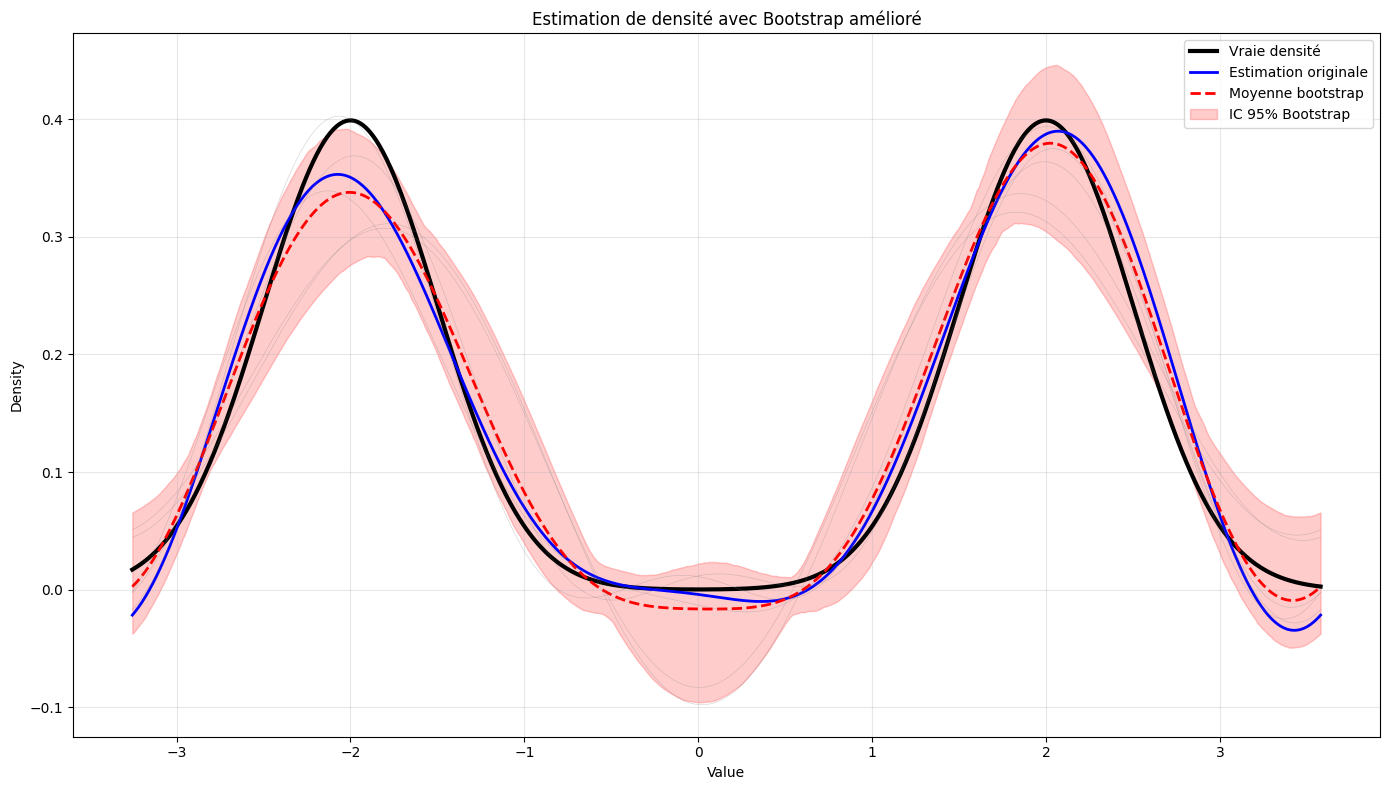

Biais moyen: 0.0124
Largeur IC moyenne: 0.1010
Couverture théorique: 95%


In [258]:
n_bootstrap = 1000
X, true_density = generate_univariate_data(distribution='mixture', n_samples=500, params={'mu1': -2, 'mu2': 2, 'sigma1': 0.5, 'sigma2': 0.5, 'weight': 0.5})
X_test = np.linspace(X.min(), X.max(), 1000)

# model de référence 
bootstrap_estimates = []
domain = [X.min(), X.max()]
model_orig = ProjectionEstimator(trigonometric_basis, domain=domain, D=8)
model_orig.fit(X)
f_original = model_orig.evaluate(X_test)


for i in range(n_bootstrap):
    indices = np.random.choice(len(X), size=len(X), replace=True)
    X_bootstrap = X[indices]

    # changement de dimension pour des modèles bootstrap plus différents
    D_boot = np.random.choice([6, 7, 8, 9, 10])
    model = ProjectionEstimator(trigonometric_basis, domain=domain, D=D_boot)
    model.fit(X_bootstrap)
    f_boot = model.evaluate(X_test)
    bootstrap_estimates.append(f_boot)

bootstrap_estimates = np.array(bootstrap_estimates)

f_mean = np.mean(bootstrap_estimates, axis=0)

# Intervalles de confiance percentiles
alpha = 0.05
lower_bound = np.percentile(bootstrap_estimates, 100 * alpha/2, axis=0)
upper_bound = np.percentile(bootstrap_estimates, 100 * (1-alpha/2), axis=0)

plt.figure(figsize=(14, 8))

plt.plot(X_test, true_density(X_test), 'k-', linewidth=3, label='Vraie densité')
plt.plot(X_test, f_original, 'b-', linewidth=2, label='Estimation originale')
plt.plot(X_test, f_mean, 'r--', linewidth=2, label='Moyenne bootstrap')

for i in range(0, min(50, n_bootstrap), 10):
    plt.plot(X_test, bootstrap_estimates[i], 'gray', alpha=0.3, linewidth=0.5)

plt.fill_between(X_test, lower_bound, upper_bound, color='red', alpha=0.2, 
                 label=f'IC 95% Bootstrap')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Estimation de densité avec Bootstrap amélioré')
plt.legend()
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


bias = f_mean - f_original
print(f"Biais moyen: {np.mean(np.abs(bias)):.4f}")
print(f"Largeur IC moyenne: {np.mean(upper_bound - lower_bound):.4f}")
print(f"Couverture théorique: 95%")

    
    # 1. initialiser un estimateur de densité par projection
    # 2. faite l'estimation de la densité sur X_bootstrap
    # 3. evaluer l'estiamtion sur X_test
    # 4. stocker les resultats de l'evaluation de f

# construire les intervalles de confiance à 95% pour la densité estimée